In [ ]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
df = pd.read_csv('soal.csv')
df.head()

,date_time,count,speed1,speed2
0,2020-06-01 00:00:00,42,74.5,73.0
1,2020-06-01 00:15:00,46,73.0,74.0
2,2020-06-01 00:30:00,50,75.5,76.0
3,2020-06-01 00:45:00,34,77.0,80.0
4,2020-06-01 01:00:00,29,81.0,80.0


In [ ]:
df.shape

(5856, 4)

In [ ]:
df.dtypes

date_time     object
count          int64
speed1       float64
speed2       float64
dtype: object

In [ ]:
df.describe(include='all')

,date_time,count,speed1,speed2
count,5856,5856.000000,5856.000000,5856.000000
unique,5856,NaN,NaN,NaN
top,2020-07-03 18:15:00,NaN,NaN,NaN
freq,1,NaN,NaN,NaN
mean,NaN,95.334016,72.870475,67.352715
std,NaN,56.356579,5.591778,20.363426
min,NaN,1.000000,7.000000,-1.000000
25%,NaN,45.000000,69.000000,69.000000
50%,NaN,98.000000,73.000000,72.000000
75%,NaN,139.000000,76.000000,76.000000


In [ ]:
df['date_time'] = pd.to_datetime(df['date_time'])
print('Min date_time:', df['date_time'].min())
print('Max date_time:', df['date_time'].max())

Min date_time: 2020-06-01 00:00:00
Max date_time: 2020-07-31 23:45:00


In [ ]:
df['minute'] = df['date_time'].dt.minute 
df['hour'] = df['date_time'].dt.hour
df['dayofweek'] = df['date_time'].dt.dayofweek
df['quarter'] = df['date_time'].dt.quarter
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year
df['dayofyear'] = df['date_time'].dt.dayofyear
df['dayofmonth'] = df['date_time'].dt.day
df['weekofyear'] = df['date_time'].dt.weekofyear
df.head()

,date_time,count,speed1,speed2,minute,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2020-06-01 00:00:00,42,74.5,73.0,0,0,0,2,6,2020,153,1,23
1,2020-06-01 00:15:00,46,73.0,74.0,15,0,0,2,6,2020,153,1,23
2,2020-06-01 00:30:00,50,75.5,76.0,30,0,0,2,6,2020,153,1,23
3,2020-06-01 00:45:00,34,77.0,80.0,45,0,0,2,6,2020,153,1,23
4,2020-06-01 01:00:00,29,81.0,80.0,0,1,0,2,6,2020,153,1,23


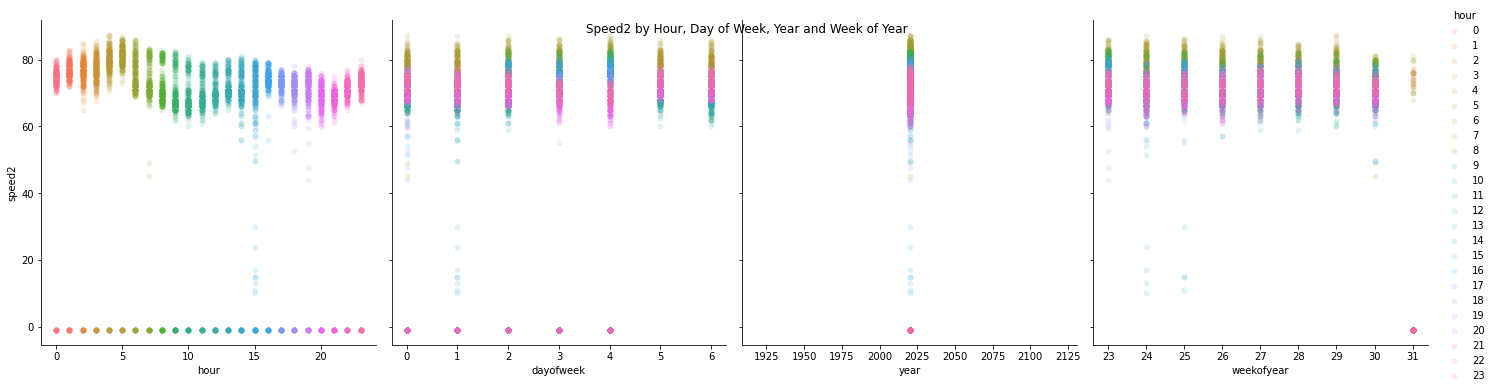

In [ ]:
sns.pairplot(data=df,
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='speed2',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0})
plt.suptitle('Speed2 by Hour, Day of Week, Year and Week of Year')
plt.show()

***
# Train/Test Split

In [ ]:
#test_first_row = (df['speed2'] == -1).argmax()
test_first_row = ((df['month'] == 7) & (df['dayofmonth'] == 27)).argmax()

In [ ]:
df_train = df[0:test_first_row]
df_test = df[test_first_row:]
df_test.head(2)

,date_time,count,speed1,speed2,minute,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
5376,2020-07-27 00:00:00,68,75.0,73.0,0,0,0,3,7,2020,209,27,31
5377,2020-07-27 00:15:00,50,72.0,74.0,15,0,0,3,7,2020,209,27,31


In [ ]:
print('Size of df train: ', df_train.shape)
print('Size of df test: ', df_test.shape)

Size of df train:  (5376, 13)
Size of df test:  (480, 13)


In [ ]:
min_date = df_test['date_time'].min()
max_date = df_test['date_time'].max()

print('Min date_time test:', df_test['date_time'].min())
print('Max date_time test:', df_test['date_time'].max())

Min date_time test: 2020-07-27 00:00:00
Max date_time test: 2020-07-31 23:45:00


In [ ]:
date1 = pd.to_datetime(min_date) - pd.DateOffset(months=1)
date2 = pd.to_datetime(max_date) - pd.DateOffset(days=1) - pd.DateOffset(months=1) 

cond1 = df_train['date_time'] >= date1
cond2 = df_train['date_time'] <= date2
df_val = df_train[cond1 & cond2]
df_val.head(2)

,date_time,count,speed1,speed2,minute,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2496,2020-06-27 00:00:00,60,69.5,71.0,0,0,5,2,6,2020,179,27,26
2497,2020-06-27 00:15:00,61,71.0,73.0,15,0,5,2,6,2020,179,27,26


***
# Predicting Using Prophet Library

In [ ]:
data = pd.DataFrame()
data['ds'] = df_train['date_time']
data['y'] = df_train['speed2'] 
data.tail()

,ds,y
5371,2020-07-26 22:45:00,75.0
5372,2020-07-26 23:00:00,75.0
5373,2020-07-26 23:15:00,74.0
5374,2020-07-26 23:30:00,74.5
5375,2020-07-26 23:45:00,75.0


In [ ]:
holidays = pd.DataFrame({
  'holiday': 'tatilat',
  'ds': pd.to_datetime(['2020-06-03', '2020-06-04', '2020-06-05', '2020-06-12',
                        '2020-06-17', '2020-06-19', '2020-06-26', '2020-07-03',
                        '2020-07-10', '2020-07-17', '2020-07-24', '2020-07-31']),
  'lower_window': 0,
  'upper_window': 1,
})

In [ ]:
# Setup and train model and fit
model = Prophet(holidays=holidays)

model.fit(data)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
# Predict on training set with model
#future = model.make_future_dataframe(periods=5)
#test_fcst = model.predict(future)
test_fcst = model.predict(df=df_test.reset_index().rename(columns={'date_time':'ds'}))
test_fcst.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,tatilat,tatilat_lower,tatilat_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-27 00:00:00,70.222798,66.837091,77.076380,70.222798,70.222798,2.292375,2.292375,2.292375,1.539681,1.539681,1.539681,0.0,0.0,0.0,0.0,0.0,0.0,0.752695,0.752695,0.752695,0.0,0.0,0.0,72.515174
1,2020-07-27 00:15:00,70.220979,68.050947,77.891469,70.220979,70.220979,2.690174,2.690174,2.690174,1.948151,1.948151,1.948151,0.0,0.0,0.0,0.0,0.0,0.0,0.742023,0.742023,0.742023,0.0,0.0,0.0,72.911152


In [ ]:
val_fcst = model.predict(df=df_val.reset_index().rename(columns={'date_time':'ds'}))
val_fcst.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,tatilat,tatilat_lower,tatilat_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-27 00:00:00,72.224115,69.543080,79.063474,72.224115,72.224115,2.332578,2.332578,2.332578,1.539681,1.539681,1.539681,2.187894,2.187894,2.187894,2.187894,2.187894,2.187894,-1.394997,-1.394997,-1.394997,0.0,0.0,0.0,74.556692
1,2020-06-27 00:15:00,72.224587,69.825102,80.080397,72.224587,72.224587,2.728296,2.728296,2.728296,1.948151,1.948151,1.948151,2.187894,2.187894,2.187894,2.187894,2.187894,2.187894,-1.407749,-1.407749,-1.407749,0.0,0.0,0.0,74.952884


***
# Visualize Outputs

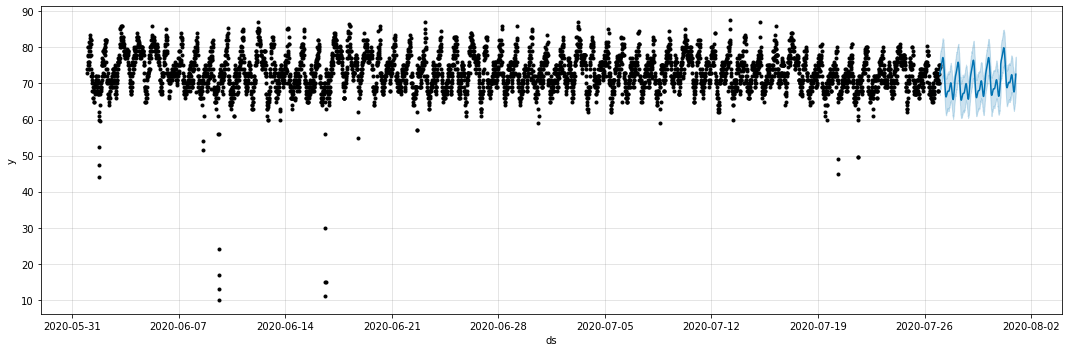

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1, figsize=(15,5))
fig = model.plot(test_fcst, ax=ax)
plt.show()

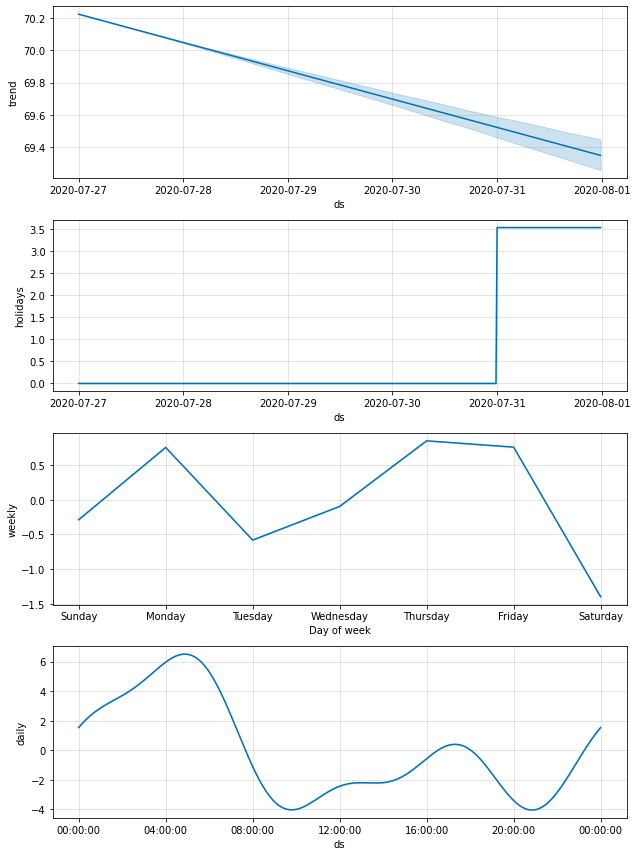

In [ ]:
# Plot the components of the model
fig = model.plot_components(test_fcst)

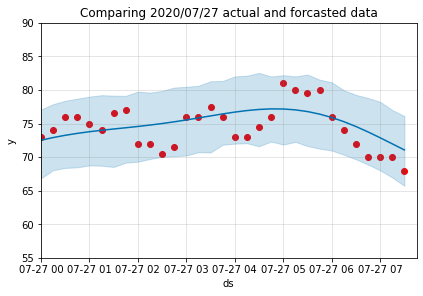

In [ ]:
# Plot the forecast with the actual 
max = (df_test['speed2'] == -1).argmax()
f, ax = plt.subplots(1)

ax.scatter(df_test[:max]['date_time'], df_test[:max]['speed2'], color='r')
fig = model.plot(test_fcst[:max], ax=ax)

ax.set_xlim([df_test['date_time'].values[0], df_test['date_time'].values[max]])
ax.set_ylim([55, 90])
plot = plt.title('Comparing 2020/07/27 actual and forcasted data')

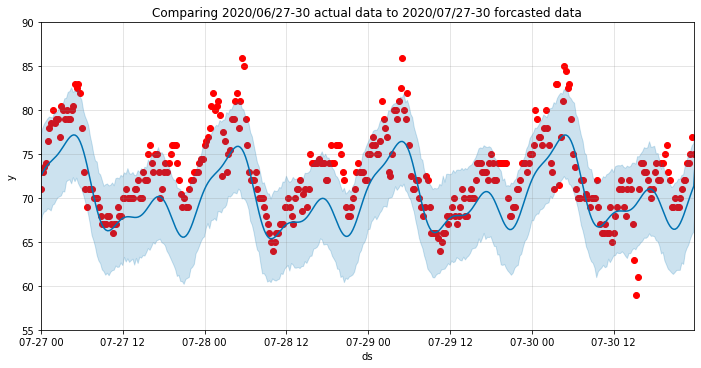

In [ ]:
# Plot the forecast with the last month's data
f, ax = plt.subplots(1, figsize=(10,5))

ax.scatter(df_val['date_time'] + pd.DateOffset(months=1), df_val['speed2'], color='r')
fig = model.plot(test_fcst, ax=ax)

ax.set_xlim([pd.to_datetime(date1) + pd.DateOffset(months=1), 
             pd.to_datetime(date2) + pd.DateOffset(months=1)])
ax.set_ylim([55, 90])
plot = plt.title('Comparing 2020/06/27-30 actual data to 2020/07/27-30 forcasted data')

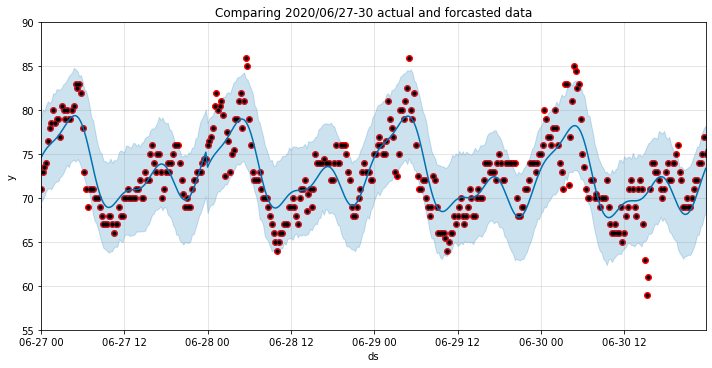

In [ ]:
# Plot the forecast with the last month's data
f, ax = plt.subplots(1, figsize=(10,5))

ax.scatter(df_val['date_time'], df_val['speed2'], color='r')
fig = model.plot(val_fcst, ax=ax)

ax.set_xlim([pd.to_datetime(date1), 
             pd.to_datetime(date2)])
ax.set_ylim([55, 90])
plot = plt.title('Comparing 2020/06/27-30 actual and forcasted data')

***
# Metric Evaluation


In [ ]:
yhat_val = val_fcst['yhat'].values
y_val = df_val['speed2'].values
 
error = np.sum(np.abs((yhat_val - y_val) / y_val))
print(error)

11.716448994966328


In [ ]:
cond1 = test_fcst['ds'] >= pd.to_datetime(date1) + pd.DateOffset(months=1)
cond2 = test_fcst['ds'] <= pd.to_datetime(date2) + pd.DateOffset(months=1)
max = (df_test['speed2'] == -1).argmax()

yhat_test = test_fcst[:max]['yhat'].values
y_test = df_test[:max]['speed2'].values
 
error = np.sum(np.abs((yhat_test - y_test) / y_test))
print(error)

0.9336723055804735
